In [2]:
from pprint import pprint
import os, sys

# import reframe test script:
sys.path.append('../reframe') # so that next line can find reframe itself ...
import reframe_imb

import reframe

In [3]:
# paths look like:
# ../output/alaska/compute-roce/gnu-openmpi/IMB_PingPong/rfm_IMB_PingPong_job.out 
# ../perflogs/alaska/compute-roce/gnu-openmpi/IMB_PingPong/IMB_PingPong.log



# find output files for this test:
def find_run_outputs(root='.', test=None, ext='.out'):
    """ Find test files within an output tree.
    
        Args:
            root: path to start searching from
            test: str, limit results to directories which contain this string (default: all)
            ext: str, limit results to files with this extension
        
        Returns a sequence of str paths.
    """
    
    # directory is soemthing like:
    # ../output/sausage-newslurm/compute/gnu8-openmpi3/IMB_MPI1Test/
    
    # TODO: use reframe/reframe/frontend/cli.py code to get the current system, something like
    # import reframe
    # import reframe.core.config as config
    # import reframe.core.runtime as runtime
    # import os

    # # assume default location!
    # print(reframe.INSTALL_PREFIX)
    # config_file = os.path.join(reframe.INSTALL_PREFIX, 'reframe/settings.py')
    # settings = config.load_settings_from_file(config_file)
    # runtime.init_runtime(settings.site_configuration, options.system,
    #                              non_default_craype=options.non_default_craype)
    
    results = []
    for (dirpath, dirnames, filenames) in os.walk(root):
        # in-place filter dirnames to avoid hidden directories:
        for idx, d in enumerate(dirnames):
            if d.startswith('.'):
                del dirnames[idx]
        for f in filenames:
            if os.path.splitext(f)[-1] == ext:
                path = os.path.join(dirpath, f)
                testdir = os.path.basename(os.path.dirname(path))
                if test is None or test in testdir:
                    results.append(path)
    return(results)
                
run_outputs = find_run_outputs('../output', 'IMB')
print(run_outputs)

['../output/alaska/compute-ib/gnu-openmpi/IMB_PingPong/rfm_IMB_PingPong_job.out', '../output/alaska/compute-ib/gnu-openmpi/IMB_Uniband/rfm_IMB_Uniband_job.out', '../output/alaska/compute-roce/gnu-openmpi/IMB_PingPong/rfm_IMB_PingPong_job.out', '../output/alaska/compute-roce/gnu-openmpi/IMB_Uniband/rfm_IMB_Uniband_job.out']


In [4]:
# load results using the same function that we use for reframe performance tests:
# TODO: add groupby= based off metadata?
results = []
for path in run_outputs:
    result = reframe_imb.read_imb_out(path)
    results.append(result)
    print('read', path)
    pprint(result['meta'])

read ../output/alaska/compute-ib/gnu-openmpi/IMB_PingPong/rfm_IMB_PingPong_job.out
{'benchmark': 'pingpong',
 'environ': 'gnu-openmpi',
 'filename': 'rfm_IMB_PingPong_job.out',
 'partition': 'compute-ib',
 'path': '../output/alaska/compute-ib/gnu-openmpi/IMB_PingPong/rfm_IMB_PingPong_job.out',
 'processes': 2,
 'sysname': 'alaska',
 'testname': 'IMB_PingPong'}
read ../output/alaska/compute-ib/gnu-openmpi/IMB_Uniband/rfm_IMB_Uniband_job.out
{'benchmark': 'uniband',
 'environ': 'gnu-openmpi',
 'filename': 'rfm_IMB_Uniband_job.out',
 'partition': 'compute-ib',
 'path': '../output/alaska/compute-ib/gnu-openmpi/IMB_Uniband/rfm_IMB_Uniband_job.out',
 'processes': 2,
 'sysname': 'alaska',
 'testname': 'IMB_Uniband'}
read ../output/alaska/compute-roce/gnu-openmpi/IMB_PingPong/rfm_IMB_PingPong_job.out
{'benchmark': 'pingpong',
 'environ': 'gnu-openmpi',
 'filename': 'rfm_IMB_PingPong_job.out',
 'partition': 'compute-roce',
 'path': '../output/alaska/compute-roce/gnu-openmpi/IMB_PingPong/rfm_IMB

In [5]:
# Group results by *testname*

test_results = {} # key: test name

for result in results:
    testname = result['meta']['testname']
    cases = test_results.setdefault(testname, [])
    cases.append(result)

for test, cases in test_results.items():
    print(test, ':')
    for c in cases:
        print('  ', c['meta']['filename'])
        #pprint(c['meta'])

IMB_PingPong :
   rfm_IMB_PingPong_job.out
   rfm_IMB_PingPong_job.out
IMB_Uniband :
   rfm_IMB_Uniband_job.out
   rfm_IMB_Uniband_job.out


In [6]:
def diff_meta(results, ignore=['path']):
    """ Given a sequence of results dicts, returns
            
            common, [difference1, difference2, ...]
        
        where each of these are dicts based on the ['meta'] properties of each result dict
        ignoring given keys
        
        TODO: describe this properly
    """
    
    meta = [r['meta'].copy() for r in results]
    
    for key in ignore:
        for m in meta:
            m.pop(key, None)
    keyvals = [set(zip(m.keys(), m.values())) for m in meta]
    common = keyvals[0].intersection(*keyvals[1:])
    differences = [dict(b.difference(common)) for b in keyvals]
    return dict(common), differences
                   
# tests:                   
c, d = diff_meta(test_results['IMB_PingPong'])
print('common:')
pprint(c)
print('differences:')
pprint(d)


common:
{'benchmark': 'pingpong',
 'environ': 'gnu-openmpi',
 'filename': 'rfm_IMB_PingPong_job.out',
 'processes': 2,
 'sysname': 'alaska',
 'testname': 'IMB_PingPong'}
differences:
[{'partition': 'compute-ib'}, {'partition': 'compute-roce'}]


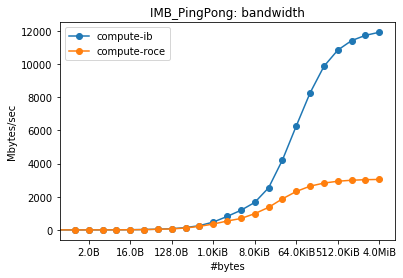

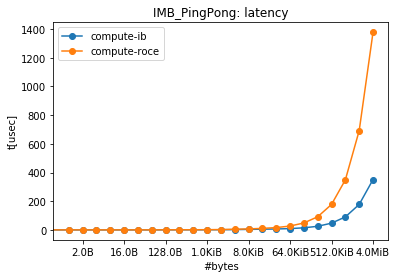

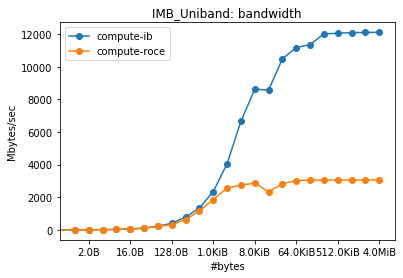

In [7]:
# Plotting:

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import ticker

# TODO: add latency for pingpong

def sizeof_fmt(num, suffix='B'):
    # from https://stackoverflow.com/a/1094933/916373
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)


PLOTS = [
    {
        'test':'IMB_PingPong',
        'xaxis':'#bytes',
        'yaxis':'Mbytes/sec',
        'metric':'bandwidth',
    },
    {
        'test':'IMB_PingPong',
        'xaxis':'#bytes',
        'yaxis':'t[usec]',
        'metric':'latency',
    },
    {
        'test':'IMB_Uniband',
        'xaxis':'#bytes',
        'yaxis':'Mbytes/sec',
        'metric':'bandwidth',
    },   
]

for plot in PLOTS:
    cases = test_results[plot['test']]
    common, differences = diff_meta(cases)
    plt.figure()
    for ix, case in enumerate(cases):
        
        data = case['data'] # TODO: change this cope with benchmark name in output instead of fixed "data" key
        unique_meta = differences[ix]
        label = '-'.join(list(unique_meta.values()))
        #plt.plot(data[plot['xaxis']], data[plot['yaxis']], 'o-', label=label)
        plt.plot(data[plot['xaxis']], data[plot['yaxis']], 'o-', label=label)
        plt.grid()
        plt.title('%s: %s' % (plot['test'], plot['metric']))
        plt.legend()
        plt.grid()
        ax = plt.gca()
        ax.set_xscale('log', basex=2)
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: sizeof_fmt(x)))
        plt.xlabel(plot['xaxis'])
        plt.ylabel(plot['yaxis'])
    

In [8]:
def get_tests(module):
    tests = []
    for name in dir(module):
        obj = getattr(module, name)
        if isinstance(obj, reframe.core.meta.RegressionTestMeta):
            tests.append(obj)
    return tests
testobjs = get_tests(reframe_imb)
print(testobjs)

[<class 'reframe_imb.IMB_Biband'>, <class 'reframe_imb.IMB_MPI1'>, <class 'reframe_imb.IMB_PingPong'>, <class 'reframe_imb.IMB_Uniband'>]


In [35]:
# Load performance records

def read_perflog(path):
    # b/c perflog prefix is '%(check_system)s/%(check_partition)s/%(check_environ)s/%(check_name)s'
    # we know that this is unique for this combo - as it was for results
    
    perf_results = {'meta':reframe_imb.parse_path_metadata(path)}
    
    with open(path) as f:
        for line in f:
            # turn the line into a dict so we can access it:
            line = line.strip()
            # TODO: read this from reframe-settings handlers_perflog.filelog.format? (is adapted tho)
            LOG_FIELDS = 'completion_time,reframe,info,jobid,perf_data,perf_unit,perf_ref'.split(',')
            record = dict(zip(LOG_FIELDS, line.split('|')))
            
            # process perf data:
            perf_var, perf_value = record['perf_data'].split('=')
            record['perf_value'] = float(perf_value) # TODO: is this always right?
            
            # make sure we have a dict of lists for this perf_var:
            # NB unit and ref shouldn't change but best place to store them
            result_fields = ('completion_time', 'jobid', 'perf_value', 'perf_unit', 'perf_ref', 'reframe')
            var_results = perf_results.setdefault(perf_var, {})
            
            # append fields from this record:
            for k in result_fields:
                var_results.setdefault(k, list()).append(record[k])
    
    return perf_results


# find relevant perf logs:
perf_outputs = find_run_outputs('../perflogs', 'IMB', '.log')
print(perf_outputs)
print()

# load them:
perf_records = []
for path in perf_outputs:
    records = read_perflog(path)
    perf_records.append(records)
    
print('total %i performance matching records' % len(perf_records))


#pprint(perf_records)

# for r in perf_records:
#      print(r['meta']['testname'])

# def group_by(seq, keyfunc):
#     """ group a sequence of nested dicts using a keyfunction
    
#         returns a dict of lists
#         unlike itertools.groupby this returns a copy not an iterator
    
#         TODO: explain properly
#     """
#     output = {}
#     for item in seq:
#         value = keyfunc(item)
#         curr = output.setdefault(value, [])
#         curr.append(item)
#     return output




['../perflogs/alaska/compute-ib/gnu-openmpi/IMB_PingPong/IMB_PingPong.log', '../perflogs/alaska/compute-ib/gnu-openmpi/IMB_Uniband/IMB_Uniband.log', '../perflogs/alaska/compute-roce/gnu-openmpi/IMB_PingPong/IMB_PingPong.log', '../perflogs/alaska/compute-roce/gnu-openmpi/IMB_Uniband/IMB_Uniband.log']

total 4 performance matching records


In [36]:
# group performance data by testname:
test_perf = group_by(perf_records, lambda x: x['meta']['testname'])
pprint(test_perf)


{'IMB_PingPong': [{'meta': {'environ': 'gnu-openmpi',
                            'filename': 'IMB_PingPong.log',
                            'partition': 'compute-ib',
                            'path': '../perflogs/alaska/compute-ib/gnu-openmpi/IMB_PingPong/IMB_PingPong.log',
                            'sysname': 'alaska',
                            'testname': 'IMB_PingPong'},
                   'pingpong_max_bandwidth': {'completion_time': ['2020-05-26T16:20:36+01:00',
                                                                  '2020-05-26T16:27:34+01:00',
                                                                  '2020-05-26T16:40:05+01:00'],
                                              'jobid': ['jobid=375',
                                                        'jobid=379',
                                                        'jobid=383'],
                                              'perf_ref': ['ref=0 (l=None, '
                                           

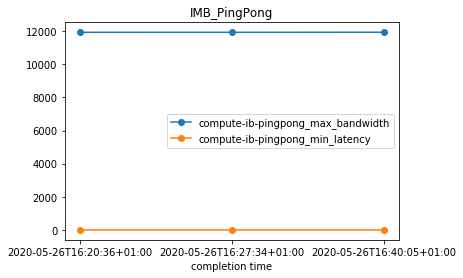

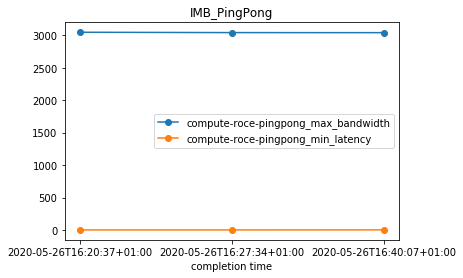

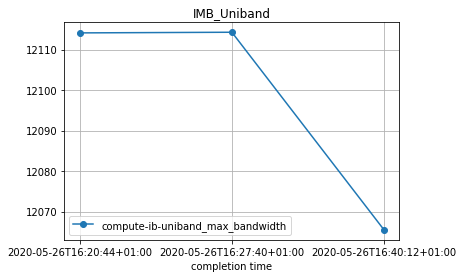

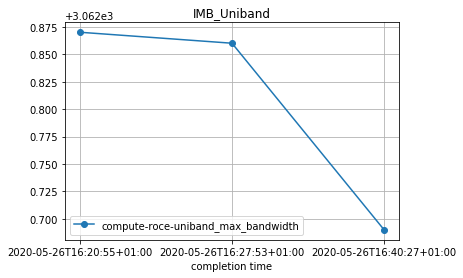

In [37]:
# Plot: here we don't need to define the plot, because we can automatically work it out:

import datetime

from matplotlib.dates import date2num

# plotting:
for test in test_perf:
    
    cases = test_perf[test]
    common, differences = diff_meta(cases)
    for ix, case in enumerate(cases):
        plt.figure()
        
        unique_meta = differences[ix]
        perf_vars = [k for k in case if k != 'meta']
        for perf_var in case:
            if perf_var == 'meta': # not a real performance var
                continue
            dates = case[perf_var]['completion_time']
            values = case[perf_var]['perf_value']
            label = '-'.join(list(unique_meta.values()) + [perf_var])
            plt.plot_date(dates, values, 'o-', label=label)
        
        
            plt.title(test)
            plt.legend()
            plt.grid()
            plt.xlabel('completion time')
            #plt.ylabel()        
        
        